# Module 1 — Prévision BVMT

**Objectifs:**
- Prédire le prix de clôture des 5 prochains jours ouvrables
- Prédire le volume journalier et la probabilité de liquidité élevée/faible

**Métriques:** RMSE, MAE, Directional Accuracy

**Pipeline:** Data Loading → Feature Engineering → Model Training → Evaluation → Export

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
import xgboost as xgb
import joblib

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

TensorFlow version: 2.20.0
XGBoost version: 3.1.3


## 1. Data Loading
Load all historical cotation files from the `data/` folder.

In [3]:
DATA_DIR = os.path.join('..', 'data')

def load_csv_files(data_dir):
    """Load all CSV cotation files."""
    csv_files = sorted(glob.glob(os.path.join(data_dir, 'histo_cotation_*.csv')))
    dfs = []
    for f in csv_files:
        df = pd.read_csv(f, sep=';', encoding='latin-1')
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        dfs.append(df)
        print(f"Loaded {os.path.basename(f)}: {len(df)} rows")
    return dfs

def load_txt_files(data_dir):
    """Load older fixed-width TXT cotation files."""
    txt_files = sorted(glob.glob(os.path.join(data_dir, 'histo_cotation_*.txt')))
    dfs = []
    for f in txt_files:
        df = pd.read_fwf(f, encoding='latin-1', skiprows=[1])  # skip the dashes line
        df.columns = df.columns.str.strip()
        # Rename columns to match CSV format if needed
        rename = {'IND_RES': 'IND_RES'}
        df = df.rename(columns=rename)
        dfs.append(df)
        print(f"Loaded {os.path.basename(f)}: {len(df)} rows")
    return dfs

csv_dfs = load_csv_files(DATA_DIR)
txt_dfs = load_txt_files(DATA_DIR)

# Combine all DataFrames
all_dfs = txt_dfs + csv_dfs

# Standardize columns across all DataFrames
standard_cols = ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE',
                 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']

cleaned_dfs = []
for df in all_dfs:
    # Keep only standard columns that exist
    available = [c for c in standard_cols if c in df.columns]
    cleaned_dfs.append(df[available])

data = pd.concat(cleaned_dfs, ignore_index=True)
print(f"\nTotal combined rows: {len(data)}")
print(f"Columns: {list(data.columns)}")

Loaded histo_cotation_2022.csv: 83939 rows
Loaded histo_cotation_2023.csv: 147209 rows
Loaded histo_cotation_2024.csv: 145381 rows
Loaded histo_cotation_2025.csv: 142853 rows
Loaded histo_cotation_2026.csv: 2275 rows
Loaded histo_cotation_2016.txt: 126065 rows
Loaded histo_cotation_2017.txt: 133687 rows
Loaded histo_cotation_2018.txt: 74594 rows
Loaded histo_cotation_2019.txt: 77588 rows
Loaded histo_cotation_2020.txt: 140415 rows
Loaded histo_cotation_2021.txt: 137370 rows

Total combined rows: 1211376
Columns: ['SEANCE', 'GROUPE', 'CODE', 'VALEUR', 'OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']


In [4]:
# Clean and prepare the data

# Strip whitespace from string columns
for col in ['CODE', 'VALEUR']:
    if col in data.columns:
        data[col] = data[col].astype(str).str.strip()

# Parse dates
data['SEANCE'] = pd.to_datetime(data['SEANCE'].astype(str).str.strip(), format='%d/%m/%Y', errors='coerce')
data = data.dropna(subset=['SEANCE'])

# Convert numeric columns
numeric_cols = ['OUVERTURE', 'CLOTURE', 'PLUS_BAS', 'PLUS_HAUT', 'QUANTITE_NEGOCIEE', 'NB_TRANSACTION', 'CAPITAUX']
for col in numeric_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Sort by date
data = data.sort_values(['CODE', 'SEANCE']).reset_index(drop=True)

# Remove rows with zero or null closing price
data = data[(data['CLOTURE'] > 0) & data['CLOTURE'].notna()]

print(f"Cleaned data: {len(data)} rows")
print(f"Date range: {data['SEANCE'].min()} to {data['SEANCE'].max()}")
print(f"Number of stocks: {data['CODE'].nunique()}")
data.head(10)

Cleaned data: 718504 rows
Date range: 2016-01-04 00:00:00 to 2025-12-31 00:00:00
Number of stocks: 1326


,SEANCE,GROUPE,CODE,VALEUR,OUVERTURE,CLOTURE,PLUS_BAS,PLUS_HAUT,QUANTITE_NEGOCIEE,NB_TRANSACTION,CAPITAUX
0,2016-01-04,11,100010,MONOPRIX,14.19,13.90,13.77,14.19,2008,21,27847.95
1,2016-01-05,11,100010,MONOPRIX,14.20,13.90,13.78,14.20,2588,26,36058.30
2,2016-01-06,11,100010,MONOPRIX,13.90,13.90,13.84,13.98,10930,42,152123.86
3,2016-01-07,11,100010,MONOPRIX,13.95,13.90,13.81,13.95,4203,24,58550.95
4,2016-01-08,11,100010,MONOPRIX,13.90,13.87,13.60,13.90,9588,43,132692.72
5,2016-01-11,11,100010,MONOPRIX,13.87,13.70,13.70,13.87,1060,9,14600.01
6,2016-01-12,11,100010,MONOPRIX,13.70,13.79,13.60,13.79,5096,32,69943.05
7,2016-01-13,11,100010,MONOPRIX,13.79,13.90,13.79,14.00,387,7,5350.38
8,2016-01-15,11,100010,MONOPRIX,13.90,13.80,13.80,14.00,2578,16,35909.00
9,2016-01-18,11,100010,MONOPRIX,13.61,13.90,13.60,13.90,901,12,12319.60


## 2. Exploratory Data Analysis

In [5]:
# Top 10 most traded stocks (by number of sessions)
stock_counts = data.groupby(['CODE', 'VALEUR']).agg(
    sessions=('SEANCE', 'count'),
    avg_volume=('QUANTITE_NEGOCIEE', 'mean'),
    avg_close=('CLOTURE', 'mean')
).sort_values('sessions', ascending=False)

top_stocks = stock_counts.head(15)
print("Top 15 stocks by number of trading sessions:")
top_stocks

Top 15 stocks by number of trading sessions:


,,sessions,avg_volume,avg_close
CODE,VALEUR,,,
TN0001000108,MONOPRIX,1256,3553.695064,5.068105
TN0007210016,ESSOUKNA,1256,1286.017516,2.044204
TN0007140015,ASSAD,1256,19543.340764,1.748376
TN0006610448,TJL DA 3/17 210717,1256,0.780255,3.735573
TN0006660070,STPIL DA1/17 20614,1256,0.675159,1.274554
TN0006660039,STPILDA0807 1/10,1256,0.070860,2.639291
TN0007270010,TPR,1256,23454.631369,5.651354
TN0001100254,SFBT,1256,36146.942675,14.590613
TN0001100452,SFBT DA 1/5 130519,1256,1.417197,4.038487


Demo stock: MONOPRIX (TN0001000108)


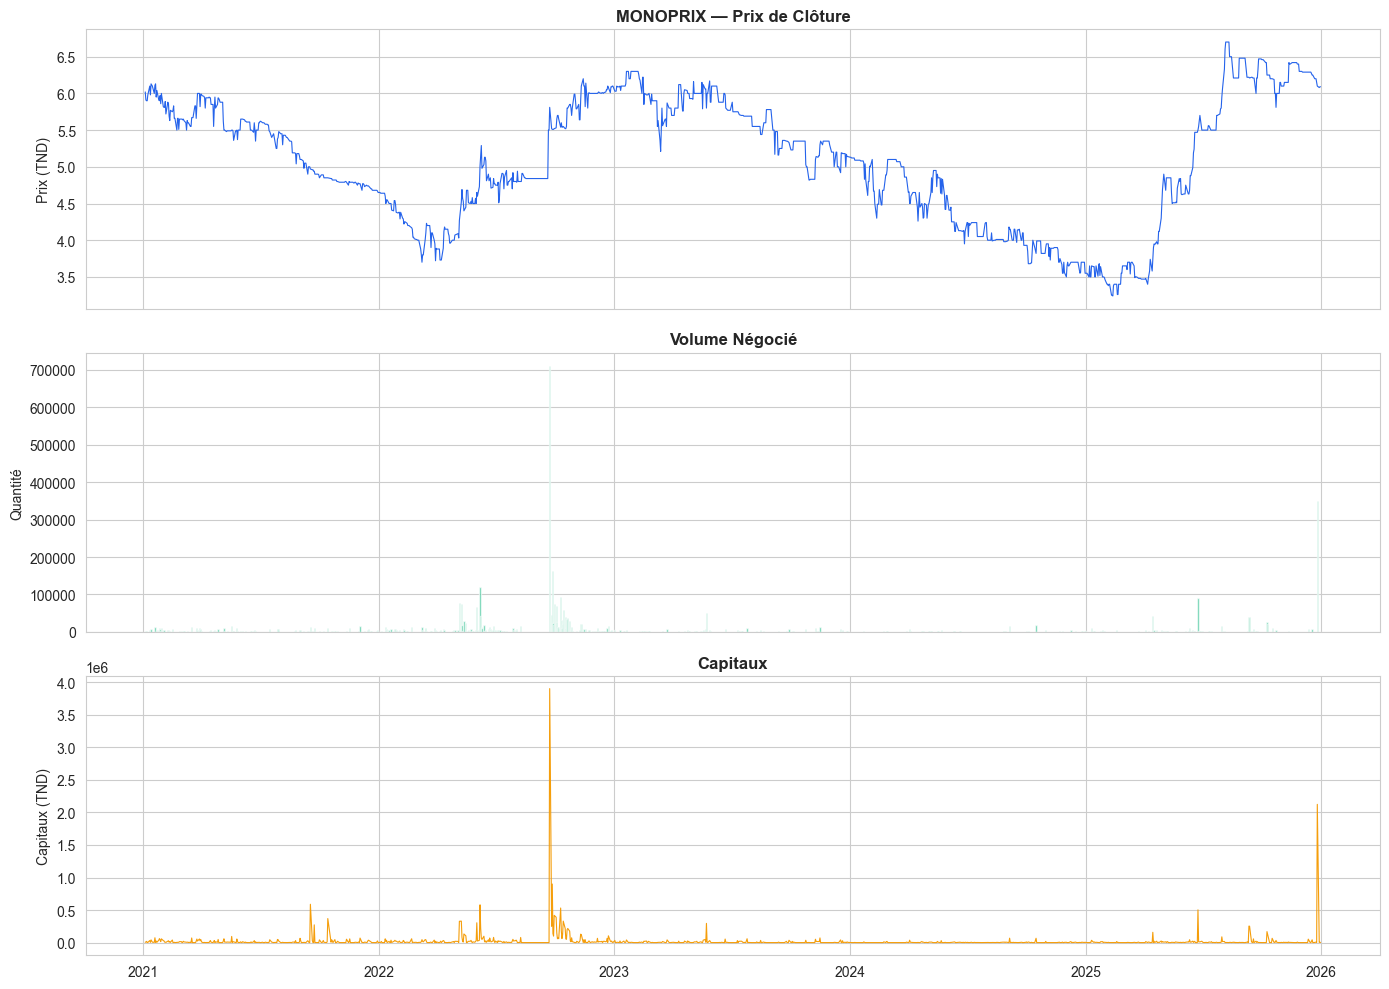

In [6]:
# Pick a representative stock to demonstrate the pipeline
# We'll use the stock with the most data points
DEMO_CODE = stock_counts.index[0][0]
DEMO_NAME = stock_counts.index[0][1]
print(f"Demo stock: {DEMO_NAME} ({DEMO_CODE})")

stock_data = data[data['CODE'] == DEMO_CODE].copy()
stock_data = stock_data.set_index('SEANCE').sort_index()

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

axes[0].plot(stock_data.index, stock_data['CLOTURE'], linewidth=0.8, color='#2563eb')
axes[0].set_title(f'{DEMO_NAME} — Prix de Clôture', fontweight='bold')
axes[0].set_ylabel('Prix (TND)')

axes[1].bar(stock_data.index, stock_data['QUANTITE_NEGOCIEE'], width=2, color='#10b981', alpha=0.7)
axes[1].set_title('Volume Négocié', fontweight='bold')
axes[1].set_ylabel('Quantité')

axes[2].plot(stock_data.index, stock_data['CAPITAUX'], linewidth=0.8, color='#f59e0b')
axes[2].set_title('Capitaux', fontweight='bold')
axes[2].set_ylabel('Capitaux (TND)')

for ax in axes:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

## 3. Feature Engineering

We build a rich feature set for each stock's time series:
- **Lagged prices**: previous N days closing prices
- **Moving averages**: 5, 10, 20, 50 day
- **Volatility**: rolling standard deviation
- **RSI** (Relative Strength Index)
- **Bollinger Bands** width
- **Volume features**: rolling mean, ratio
- **Returns**: daily, cumulative
- **Calendar**: day of week

In [7]:
def compute_rsi(series, period=14):
    """Compute Relative Strength Index."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def engineer_features(df, lookback=30):
    """
    Engineer features for a single stock's DataFrame.
    Expects columns: CLOTURE, OUVERTURE, PLUS_HAUT, PLUS_BAS, QUANTITE_NEGOCIEE, CAPITAUX, NB_TRANSACTION
    Index should be datetime (SEANCE).
    """
    feat = pd.DataFrame(index=df.index)

    # ── Price features ──
    feat['close'] = df['CLOTURE']
    feat['open'] = df['OUVERTURE']
    feat['high'] = df['PLUS_HAUT']
    feat['low'] = df['PLUS_BAS']
    feat['volume'] = df['QUANTITE_NEGOCIEE']

    # Daily return
    feat['return_1d'] = feat['close'].pct_change()
    feat['return_5d'] = feat['close'].pct_change(5)
    feat['return_10d'] = feat['close'].pct_change(10)

    # Lagged closing prices
    for lag in [1, 2, 3, 5, 10, 20]:
        feat[f'close_lag_{lag}'] = feat['close'].shift(lag)

    # Moving averages
    for window in [5, 10, 20, 50]:
        feat[f'ma_{window}'] = feat['close'].rolling(window).mean()
        feat[f'ma_ratio_{window}'] = feat['close'] / feat[f'ma_{window}']

    # Exponential moving averages
    for span in [12, 26]:
        feat[f'ema_{span}'] = feat['close'].ewm(span=span).mean()

    # MACD
    feat['macd'] = feat['ema_12'] - feat['ema_26']
    feat['macd_signal'] = feat['macd'].ewm(span=9).mean()
    feat['macd_hist'] = feat['macd'] - feat['macd_signal']

    # Volatility
    feat['volatility_5'] = feat['return_1d'].rolling(5).std()
    feat['volatility_20'] = feat['return_1d'].rolling(20).std()

    # RSI
    feat['rsi_14'] = compute_rsi(feat['close'], 14)

    # Bollinger Bands
    bb_ma = feat['close'].rolling(20).mean()
    bb_std = feat['close'].rolling(20).std()
    feat['bb_upper'] = bb_ma + 2 * bb_std
    feat['bb_lower'] = bb_ma - 2 * bb_std
    feat['bb_width'] = (feat['bb_upper'] - feat['bb_lower']) / bb_ma
    feat['bb_position'] = (feat['close'] - feat['bb_lower']) / (feat['bb_upper'] - feat['bb_lower'])

    # Volume features
    feat['volume_ma_5'] = feat['volume'].rolling(5).mean()
    feat['volume_ma_20'] = feat['volume'].rolling(20).mean()
    feat['volume_ratio'] = feat['volume'] / feat['volume_ma_20']

    # Candlestick patterns
    feat['body'] = feat['close'] - feat['open']
    feat['body_pct'] = feat['body'] / feat['open']
    feat['upper_shadow'] = feat['high'] - feat[['close', 'open']].max(axis=1)
    feat['lower_shadow'] = feat[['close', 'open']].min(axis=1) - feat['low']

    # Calendar features
    feat['day_of_week'] = df.index.dayofweek
    feat['month'] = df.index.month

    # Capitaux
    feat['capitaux'] = df['CAPITAUX']
    feat['capitaux_ma_10'] = feat['capitaux'].rolling(10).mean()

    return feat


# Apply to the demo stock
features = engineer_features(stock_data)
print(f"Features shape: {features.shape}")
print(f"\nFeature columns ({len(features.columns)}):")
print(list(features.columns))

Features shape: (1256, 45)

Feature columns (45):
['close', 'open', 'high', 'low', 'volume', 'return_1d', 'return_5d', 'return_10d', 'close_lag_1', 'close_lag_2', 'close_lag_3', 'close_lag_5', 'close_lag_10', 'close_lag_20', 'ma_5', 'ma_ratio_5', 'ma_10', 'ma_ratio_10', 'ma_20', 'ma_ratio_20', 'ma_50', 'ma_ratio_50', 'ema_12', 'ema_26', 'macd', 'macd_signal', 'macd_hist', 'volatility_5', 'volatility_20', 'rsi_14', 'bb_upper', 'bb_lower', 'bb_width', 'bb_position', 'volume_ma_5', 'volume_ma_20', 'volume_ratio', 'body', 'body_pct', 'upper_shadow', 'lower_shadow', 'day_of_week', 'month', 'capitaux', 'capitaux_ma_10']


## 4. Prepare Training Data for Multi-Step Price Forecasting

We predict the closing price for the next **5 business days** (t+1 to t+5).

In [11]:
FORECAST_HORIZON = 5  # predict next 5 trading days

def create_targets(df, horizon=FORECAST_HORIZON):
    """
    Create target columns: future closing prices at t+1, t+2, ..., t+horizon.
    """
    targets = pd.DataFrame(index=df.index)
    for h in range(1, horizon + 1):
        targets[f'target_close_t{h}'] = df['close'].shift(-h)
        targets[f'target_volume_t{h}'] = df['volume'].shift(-h)
    return targets


targets = create_targets(features)

# Combine features + targets, replace inf with NaN, then drop NaN rows
full_df = pd.concat([features, targets], axis=1)
inf_count = np.isinf(full_df.select_dtypes(include=np.number)).sum().sum()
print(f"Infinite values found: {inf_count}")
full_df = full_df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Full dataset shape (after dropping NaN/inf): {full_df.shape}")
print(f"Date range: {full_df.index.min()} → {full_df.index.max()}")

Infinite values found: 30
Full dataset shape (after dropping NaN/inf): (1159, 55)
Date range: 2021-03-15 00:00:00 → 2025-12-24 00:00:00


In [12]:
# Define feature columns (exclude raw close/open/high/low/volume and targets)
target_cols = [c for c in full_df.columns if c.startswith('target_')]
price_target_cols = [c for c in target_cols if 'close' in c]
volume_target_cols = [c for c in target_cols if 'volume' in c]

# Features for XGBoost (all numeric features except targets)
feature_cols = [c for c in full_df.columns if c not in target_cols]

print(f"Feature columns: {len(feature_cols)}")
print(f"Price target columns: {price_target_cols}")
print(f"Volume target columns: {volume_target_cols}")

# Train/test split — time-based (last 60 trading days = ~3 months as test)
TEST_DAYS = 60

X = full_df[feature_cols]
y_price = full_df[price_target_cols]
y_volume = full_df[volume_target_cols]

X_train, X_test = X.iloc[:-TEST_DAYS], X.iloc[-TEST_DAYS:]
y_price_train, y_price_test = y_price.iloc[:-TEST_DAYS], y_price.iloc[-TEST_DAYS:]
y_volume_train, y_volume_test = y_volume.iloc[:-TEST_DAYS], y_volume.iloc[-TEST_DAYS:]

print(f"\nTrain set: {len(X_train)} samples ({X_train.index.min()} → {X_train.index.max()})")
print(f"Test set:  {len(X_test)} samples ({X_test.index.min()} → {X_test.index.max()})")

Feature columns: 45
Price target columns: ['target_close_t1', 'target_close_t2', 'target_close_t3', 'target_close_t4', 'target_close_t5']
Volume target columns: ['target_volume_t1', 'target_volume_t2', 'target_volume_t3', 'target_volume_t4', 'target_volume_t5']

Train set: 1099 samples (2021-03-15 00:00:00 → 2025-09-29 00:00:00)
Test set:  60 samples (2025-09-30 00:00:00 → 2025-12-24 00:00:00)


## 5. Model Training — XGBoost (Price Forecasting)

Train one XGBoost regressor per forecast horizon (direct multi-step strategy).

In [13]:
# Train XGBoost models for each horizon
xgb_models = {}

for h in range(1, FORECAST_HORIZON + 1):
    target_col = f'target_close_t{h}'
    print(f"\nTraining XGBoost for t+{h} ...")

    model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0,
        early_stopping_rounds=30,
    )

    model.fit(
        X_train, y_price_train[target_col],
        eval_set=[(X_test, y_price_test[target_col])],
        verbose=False,
    )

    xgb_models[h] = model

    # Quick evaluation
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_price_test[target_col], y_pred))
    mae = mean_absolute_error(y_price_test[target_col], y_pred)
    print(f"  t+{h}: RMSE={rmse:.4f}, MAE={mae:.4f}")

print("\n✓ All XGBoost price models trained.")


Training XGBoost for t+1 ...
  t+1: RMSE=0.1218, MAE=0.0976

Training XGBoost for t+2 ...
  t+2: RMSE=0.1256, MAE=0.1021

Training XGBoost for t+3 ...
  t+3: RMSE=0.1426, MAE=0.1136

Training XGBoost for t+4 ...
  t+4: RMSE=0.1620, MAE=0.1320

Training XGBoost for t+5 ...
  t+5: RMSE=0.1744, MAE=0.1502

✓ All XGBoost price models trained.


## 6. Model Training — LSTM (Price Forecasting)

Compare with an LSTM model using the same features.

In [14]:
# Scale features for LSTM
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_price_train)
y_test_scaled = scaler_y.transform(y_price_test)

# Reshape for LSTM: (samples, timesteps=1, features)
# We use a sliding window of LOOKBACK days
LOOKBACK = 20

def create_lstm_sequences(X, y, lookback=LOOKBACK):
    """Create sequences for LSTM from 2D feature arrays."""
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i - lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_lstm_sequences(X_train_scaled, y_train_scaled)
X_test_lstm, y_test_lstm = create_lstm_sequences(X_test_scaled, y_test_scaled)

print(f"LSTM train shape: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
print(f"LSTM test shape:  X={X_test_lstm.shape}, y={y_test_lstm.shape}")

LSTM train shape: X=(1079, 20, 45), y=(1079, 5)
LSTM test shape:  X=(40, 20, 45), y=(40, 5)


In [15]:
# Build LSTM model
n_features = X_train_lstm.shape[2]
n_outputs = FORECAST_HORIZON  # 5 days

lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(LOOKBACK, n_features)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(n_outputs)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        89,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,741 (549.77 KB)

 Trainable params: 140,741 (549.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0282 - mae: 0.1224 - val_loss: 0.0052 - val_mae: 0.0632
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0092 - mae: 0.0743 - val_loss: 0.0091 - val_mae: 0.0878
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0077 - mae: 0.0682 - val_loss: 0.0065 - val_mae: 0.0748
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - mae: 0.0612 - val_loss: 0.0021 - val_mae: 0.0386
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0056 - mae: 0.0577 - val_loss: 0.0021 - val_mae: 0.0370
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - mae: 0.0585 - val_loss: 8.9490e-04 - val_mae: 0.0226
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0068 - mae: 0.0636 - val_loss: 0.0042 - val_mae: 0.0590
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048 - mae: 0.0538 - val_loss: 0.0025 - val_mae: 0.0438
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

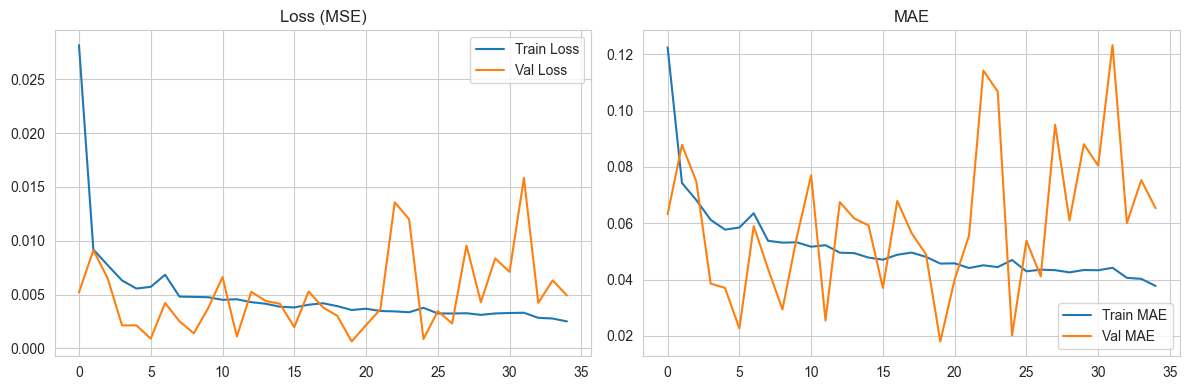

In [16]:
# Train LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss (MSE)')
axes[0].legend()

axes[1].plot(history.history['mae'], label='Train MAE')
axes[1].plot(history.history['val_mae'], label='Val MAE')
axes[1].set_title('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Volume & Liquidity Model

In [19]:
# Volume Prediction — XGBoost
volume_models = {}

for h in range(1, FORECAST_HORIZON + 1):
    target_col = f'target_volume_t{h}'
    print(f"Training volume XGBoost for t+{h} ...")

    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0,
        early_stopping_rounds=20,
    )

    model.fit(
        X_train, y_volume_train[target_col],
        eval_set=[(X_test, y_volume_test[target_col])],
        verbose=False,
    )

    volume_models[h] = model
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_volume_test[target_col], y_pred))
    mae = mean_absolute_error(y_volume_test[target_col], y_pred)
    print(f"  t+{h}: RMSE={rmse:.2f}, MAE={mae:.2f}")

print("\n✓ All volume models trained.")

Training volume XGBoost for t+1 ...
  t+1: RMSE=4762.03, MAE=3337.96
Training volume XGBoost for t+2 ...
  t+2: RMSE=44444.22, MAE=8349.48
Training volume XGBoost for t+3 ...
  t+3: RMSE=44875.70, MAE=8872.04
Training volume XGBoost for t+4 ...
  t+4: RMSE=44878.38, MAE=8839.94
Training volume XGBoost for t+5 ...
  t+5: RMSE=44880.20, MAE=8824.93

✓ All volume models trained.


In [20]:
# Liquidity Classification
# Define high/low liquidity based on volume being above/below the 20-day moving average

def create_liquidity_labels(df, threshold_quantile=0.5):
    """
    Label each day as high (1) or low (0) liquidity based on rolling median.
    """
    rolling_median = df['volume'].rolling(20).median()
    labels = (df['volume'] > rolling_median).astype(int)
    return labels

# Create liquidity targets for next 5 days
liquidity_labels = create_liquidity_labels(features)
liquidity_targets = pd.DataFrame(index=features.index)
for h in range(1, FORECAST_HORIZON + 1):
    liquidity_targets[f'liquidity_t{h}'] = liquidity_labels.shift(-h)

# Combine with features, replace inf with NaN, then drop NaN rows
liq_df = pd.concat([features, liquidity_targets], axis=1)
liq_df = liq_df.replace([np.inf, -np.inf], np.nan).dropna()

liq_X = liq_df[feature_cols]
liq_X_train, liq_X_test = liq_X.iloc[:-TEST_DAYS], liq_X.iloc[-TEST_DAYS:]

# Train a classifier for each horizon
liquidity_models = {}
for h in range(1, FORECAST_HORIZON + 1):
    target_col = f'liquidity_t{h}'
    y_liq = liq_df[target_col]
    y_train_liq = y_liq.iloc[:-TEST_DAYS]
    y_test_liq = y_liq.iloc[-TEST_DAYS:]

    clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
    clf.fit(liq_X_train, y_train_liq)

    acc = clf.score(liq_X_test, y_test_liq)
    print(f"  Liquidity t+{h}: Accuracy={acc:.4f}")
    liquidity_models[h] = clf

print("\n✓ Liquidity classifiers trained.")

  Liquidity t+1: Accuracy=0.5833
  Liquidity t+2: Accuracy=0.5500
  Liquidity t+3: Accuracy=0.3667
  Liquidity t+4: Accuracy=0.4500
  Liquidity t+5: Accuracy=0.4833

✓ Liquidity classifiers trained.


## 8. Comprehensive Evaluation

Compute RMSE, MAE, and **Directional Accuracy** for both XGBoost and LSTM.

In [21]:
def directional_accuracy(y_true, y_pred, y_prev):
    """
    Fraction of times the predicted direction (up/down) matches actual direction.
    """
    actual_dir = np.sign(y_true - y_prev)
    pred_dir = np.sign(y_pred - y_prev)
    return np.mean(actual_dir == pred_dir)


# ── XGBoost Evaluation ──
print("="*60)
print("XGBoost Price Forecast — Test Set Metrics")
print("="*60)

xgb_results = []
xgb_predictions = pd.DataFrame(index=X_test.index)

for h in range(1, FORECAST_HORIZON + 1):
    y_true = y_price_test[f'target_close_t{h}'].values
    y_pred = xgb_models[h].predict(X_test)
    y_prev = X_test['close'].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred, y_prev)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    xgb_results.append({'Horizon': f't+{h}', 'RMSE': rmse, 'MAE': mae, 'DA%': da*100, 'MAPE%': mape})
    xgb_predictions[f'pred_t{h}'] = y_pred

xgb_metrics_df = pd.DataFrame(xgb_results)
print(xgb_metrics_df.to_string(index=False))

# ── LSTM Evaluation ──
print("\n" + "="*60)
print("LSTM Price Forecast — Test Set Metrics")
print("="*60)

lstm_pred_scaled = lstm_model.predict(X_test_lstm)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_lstm)

lstm_results = []
# Use the previous close from the test set (aligned with the LSTM sequences)
prev_close_lstm = X_test.iloc[LOOKBACK:]['close'].values

for h in range(FORECAST_HORIZON):
    y_true = y_test_actual[:, h]
    y_pred = lstm_pred[:, h]
    y_prev = prev_close_lstm[:len(y_true)]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    da = directional_accuracy(y_true, y_pred, y_prev)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    lstm_results.append({'Horizon': f't+{h+1}', 'RMSE': rmse, 'MAE': mae, 'DA%': da*100, 'MAPE%': mape})

lstm_metrics_df = pd.DataFrame(lstm_results)
print(lstm_metrics_df.to_string(index=False))

XGBoost Price Forecast — Test Set Metrics
Horizon     RMSE      MAE       DA%    MAPE%
    t+1 0.121835 0.097621 26.666667 1.561766
    t+2 0.125557 0.102096 43.333333 1.633805
    t+3 0.142642 0.113637 55.000000 1.820983
    t+4 0.161954 0.131976 56.666667 2.116426
    t+5 0.174439 0.150236 63.333333 2.407041

LSTM Price Forecast — Test Set Metrics
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Horizon     RMSE      MAE  DA%    MAPE%
    t+1 0.063051 0.047544 20.0 0.755185
    t+2 0.071497 0.051388 37.5 0.816199
    t+3 0.079035 0.063404 37.5 1.010710
    t+4 0.106579 0.076593 55.0 1.212948
    t+5 0.106030 0.073035 62.5 1.157605


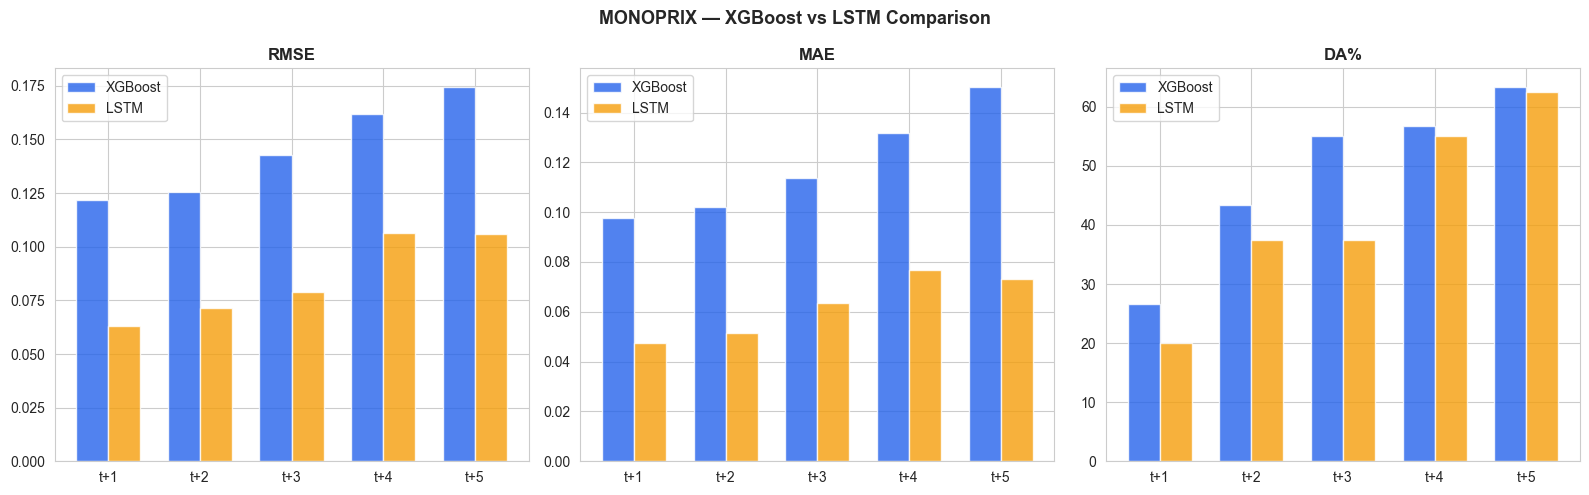

In [22]:
# ── Comparison bar chart ──
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x = np.arange(FORECAST_HORIZON)
width = 0.35

for i, metric in enumerate(['RMSE', 'MAE', 'DA%']):
    xgb_vals = xgb_metrics_df[metric].values
    lstm_vals = lstm_metrics_df[metric].values

    axes[i].bar(x - width/2, xgb_vals, width, label='XGBoost', color='#2563eb', alpha=0.8)
    axes[i].bar(x + width/2, lstm_vals, width, label='LSTM', color='#f59e0b', alpha=0.8)
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([f't+{h+1}' for h in range(FORECAST_HORIZON)])
    axes[i].set_title(metric, fontweight='bold')
    axes[i].legend()

plt.suptitle(f'{DEMO_NAME} — XGBoost vs LSTM Comparison', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()

## 9. Visualisation — Prévision vs Réel (avec Intervalles de Confiance)

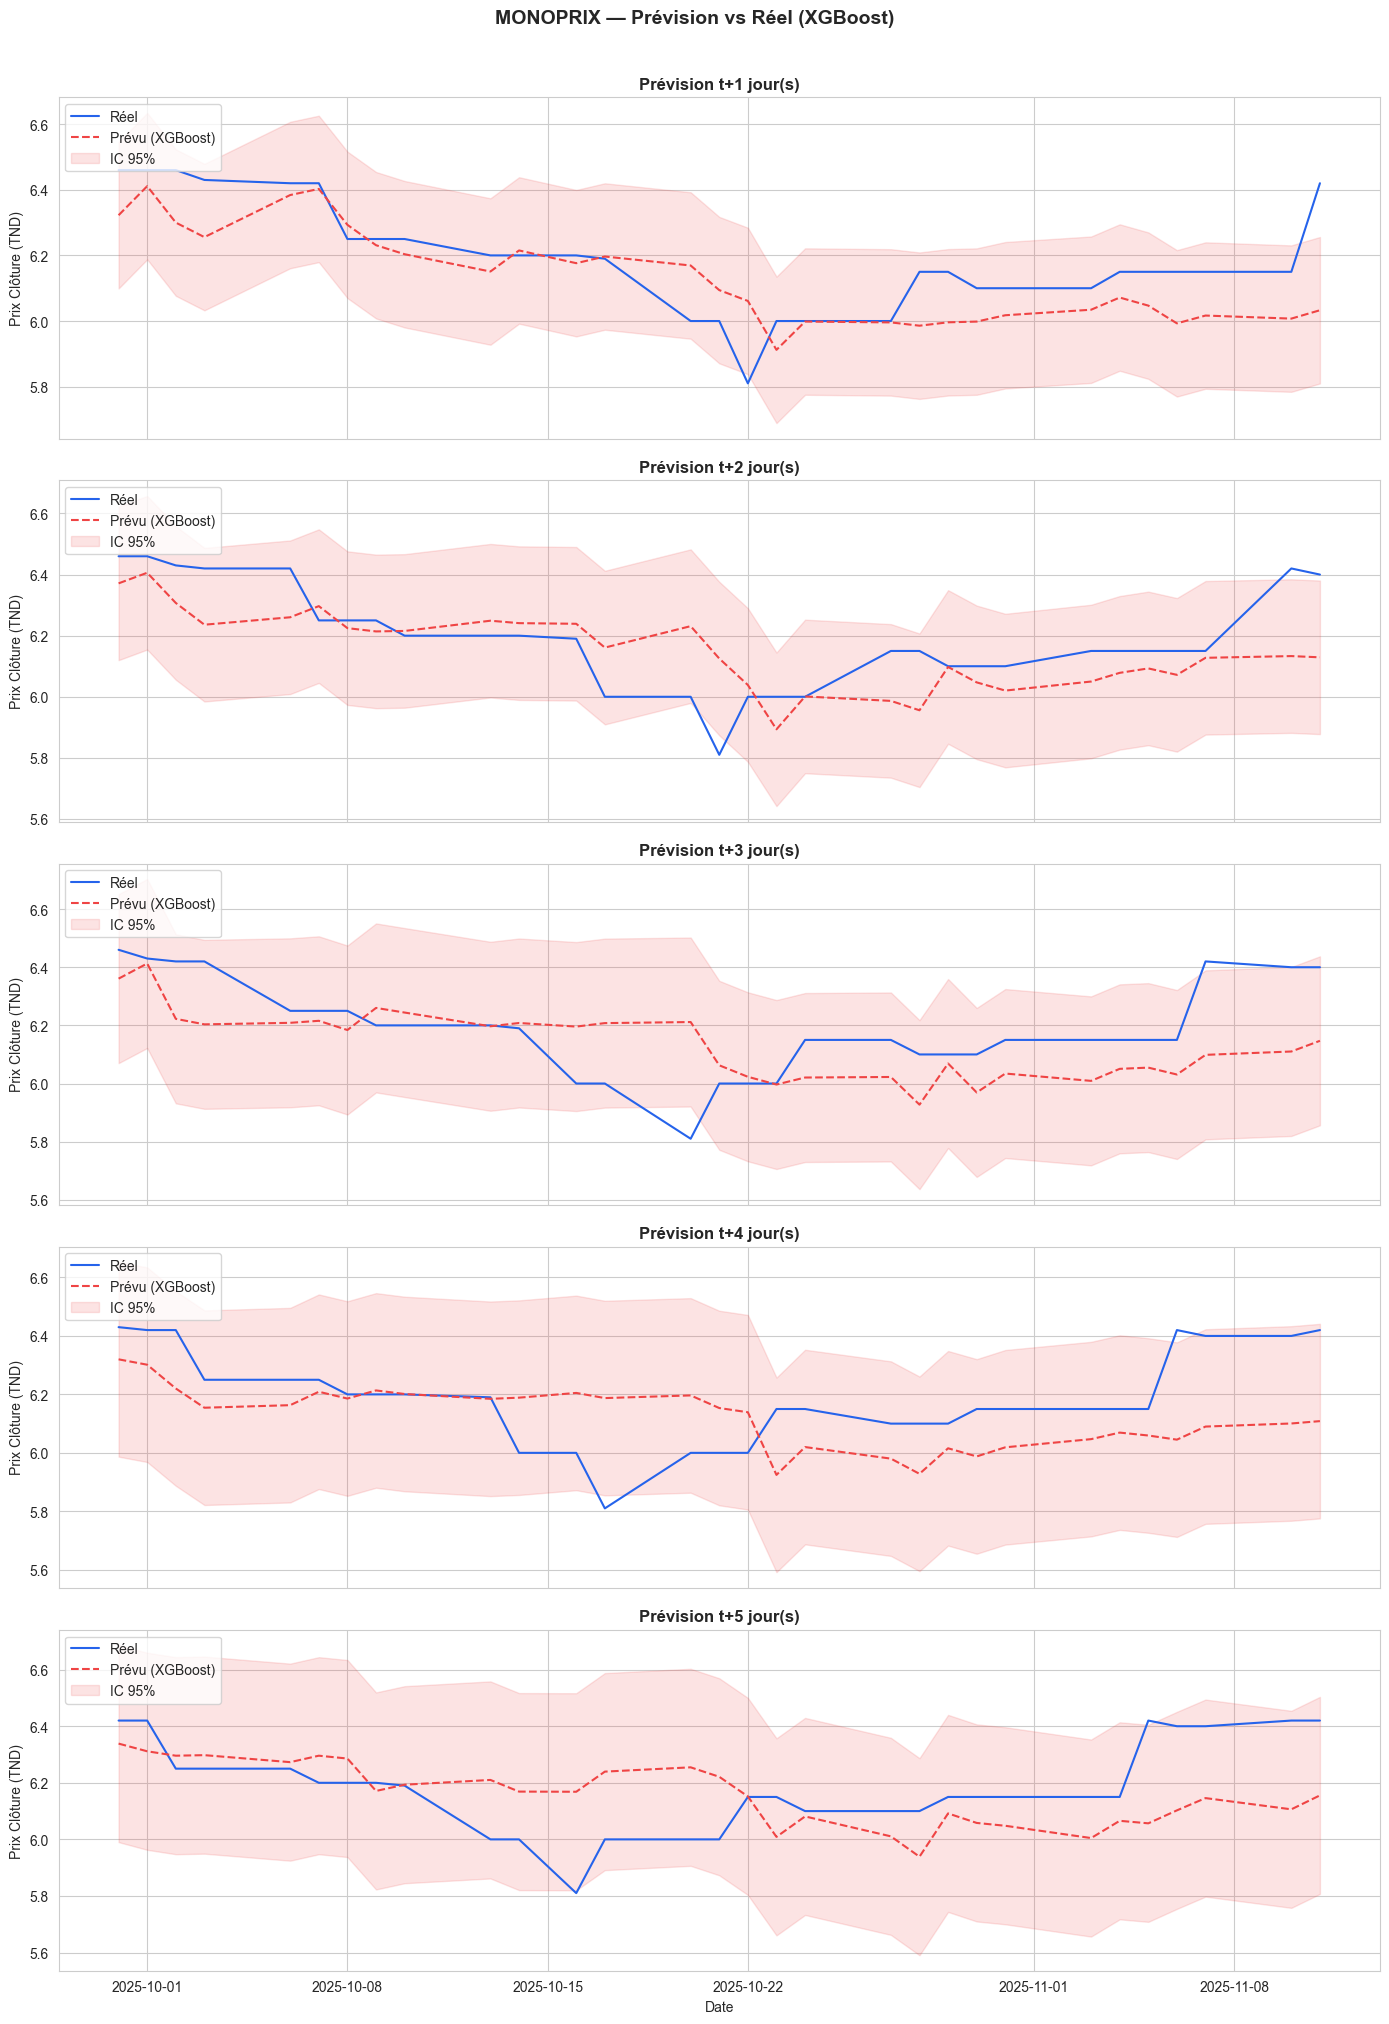

In [23]:
# Plot forecast vs actual for the last N test days using XGBoost
# Pick a window of 30 consecutive test days
PLOT_WINDOW = min(30, len(X_test) - FORECAST_HORIZON)

fig, axes = plt.subplots(FORECAST_HORIZON, 1, figsize=(14, 4 * FORECAST_HORIZON), sharex=True)

for h in range(1, FORECAST_HORIZON + 1):
    ax = axes[h-1]
    dates = X_test.index[:PLOT_WINDOW]
    actual = y_price_test[f'target_close_t{h}'].values[:PLOT_WINDOW]
    predicted = xgb_models[h].predict(X_test)[:PLOT_WINDOW]

    # Confidence interval (using residual std)
    residuals = actual - predicted
    std_res = np.std(residuals)

    ax.plot(dates, actual, label='Réel', color='#2563eb', linewidth=1.5)
    ax.plot(dates, predicted, label='Prévu (XGBoost)', color='#ef4444', linewidth=1.5, linestyle='--')
    ax.fill_between(dates,
                    predicted - 1.96 * std_res,
                    predicted + 1.96 * std_res,
                    alpha=0.15, color='#ef4444', label='IC 95%')
    ax.set_title(f'Prévision t+{h} jour(s)', fontweight='bold')
    ax.set_ylabel('Prix Clôture (TND)')
    ax.legend(loc='upper left')

axes[-1].set_xlabel('Date')
plt.suptitle(f'{DEMO_NAME} — Prévision vs Réel (XGBoost)', fontweight='bold', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

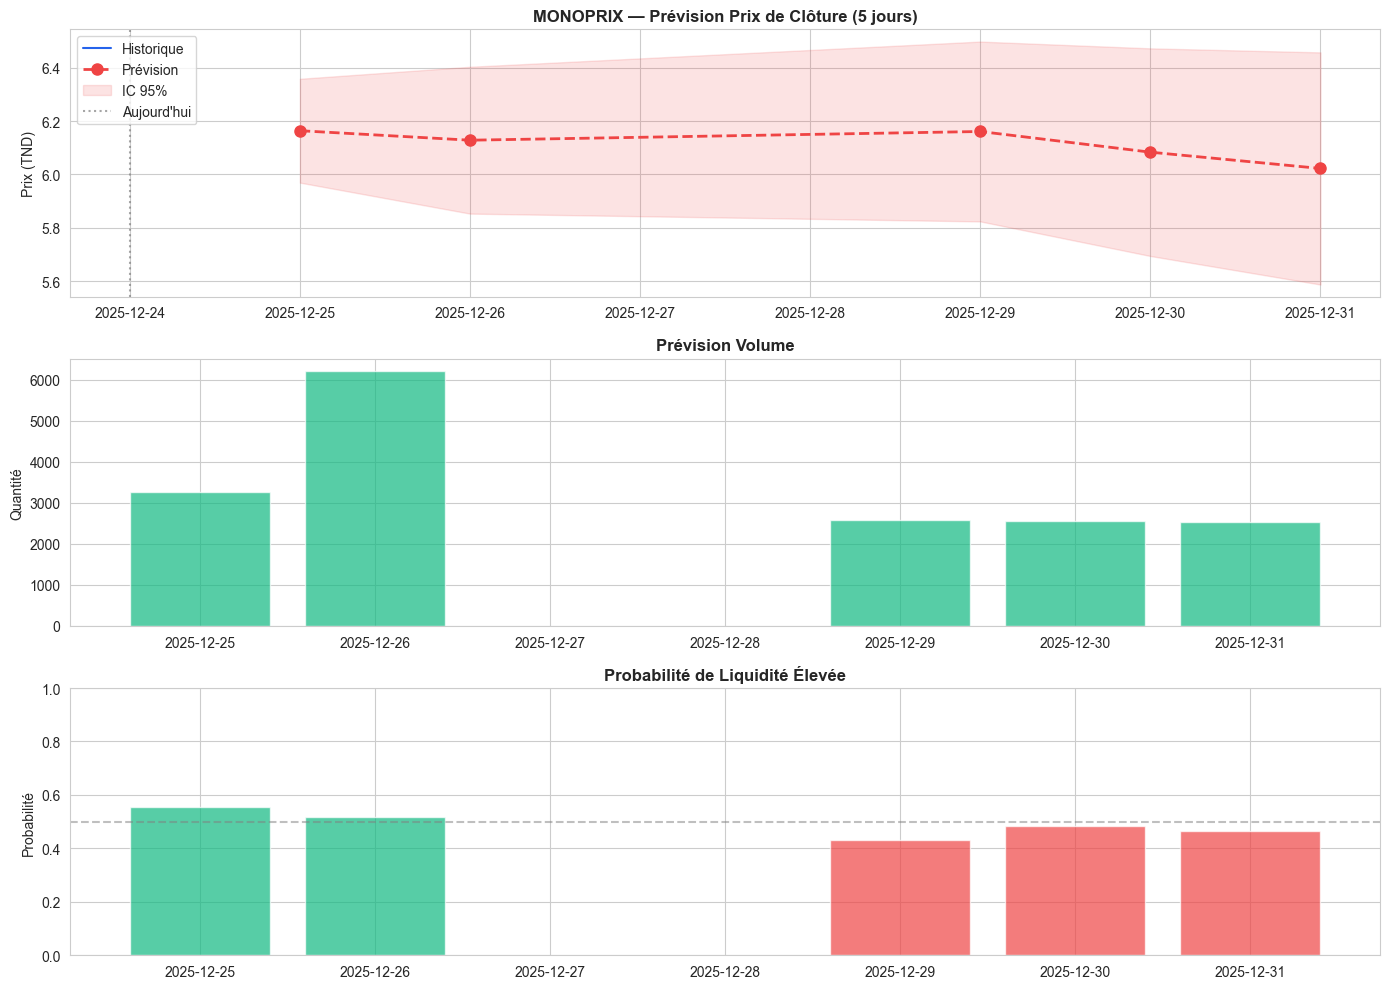


Prévisions depuis 2025-12-24 :
      Date Prix Clôture Prévu Volume Prévu Prob. Liquidité Haute
2025-12-25          6.164 TND        3,266                 55.4%
2025-12-26          6.129 TND        6,196                 51.9%
2025-12-29          6.161 TND        2,587                 43.0%
2025-12-30          6.084 TND        2,553                 48.5%
2025-12-31          6.023 TND        2,533                 46.6%


In [24]:
# Rolling 5-day forecast visualization (more realistic: one window ahead)
# Shows what a user would see: from today, here are the next 5 predicted prices

last_idx = -1  # Use the last available day as "today"
today_features = X_test.iloc[[last_idx]]
today_date = X_test.index[last_idx]

# Generate next 5 business days from today
future_dates = pd.bdate_range(start=today_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON)

# Predictions
price_preds = [xgb_models[h].predict(today_features)[0] for h in range(1, FORECAST_HORIZON + 1)]
volume_preds = [volume_models[h].predict(today_features)[0] for h in range(1, FORECAST_HORIZON + 1)]
liquidity_probs = [liquidity_models[h].predict_proba(today_features)[0][1] for h in range(1, FORECAST_HORIZON + 1)]

# Historical context (last 30 days)
hist_window = 30
hist_dates = X_test.index[max(0, last_idx - hist_window):last_idx + 1]
hist_prices = X_test['close'].iloc[max(0, last_idx - hist_window):last_idx + 1]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Price forecast
axes[0].plot(hist_dates, hist_prices, color='#2563eb', linewidth=1.5, label='Historique')
axes[0].plot(future_dates, price_preds, 'o--', color='#ef4444', linewidth=2, markersize=8, label='Prévision')
# Confidence interval
std_price = np.std(y_price_test[f'target_close_t1'].values - xgb_models[1].predict(X_test)) * np.sqrt(np.arange(1, FORECAST_HORIZON + 1))
axes[0].fill_between(future_dates,
                     np.array(price_preds) - 1.96 * std_price,
                     np.array(price_preds) + 1.96 * std_price,
                     alpha=0.15, color='#ef4444', label='IC 95%')
axes[0].axvline(today_date, color='gray', linestyle=':', alpha=0.7, label="Aujourd'hui")
axes[0].set_title(f'{DEMO_NAME} — Prévision Prix de Clôture (5 jours)', fontweight='bold')
axes[0].set_ylabel('Prix (TND)')
axes[0].legend()

# Volume forecast
axes[1].bar(future_dates, volume_preds, width=0.8, color='#10b981', alpha=0.7)
axes[1].set_title('Prévision Volume', fontweight='bold')
axes[1].set_ylabel('Quantité')

# Liquidity probability
colors = ['#10b981' if p > 0.5 else '#ef4444' for p in liquidity_probs]
axes[2].bar(future_dates, liquidity_probs, width=0.8, color=colors, alpha=0.7)
axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Probabilité de Liquidité Élevée', fontweight='bold')
axes[2].set_ylabel('Probabilité')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print predictions table
pred_df = pd.DataFrame({
    'Date': future_dates.strftime('%Y-%m-%d'),
    'Prix Clôture Prévu': [f'{p:.3f} TND' for p in price_preds],
    'Volume Prévu': [f'{int(v):,}' for v in volume_preds],
    'Prob. Liquidité Haute': [f'{p:.1%}' for p in liquidity_probs],
})
print("\nPrévisions depuis", today_date.strftime('%Y-%m-%d'), ":")
print(pred_df.to_string(index=False))

## 10. Feature Importance

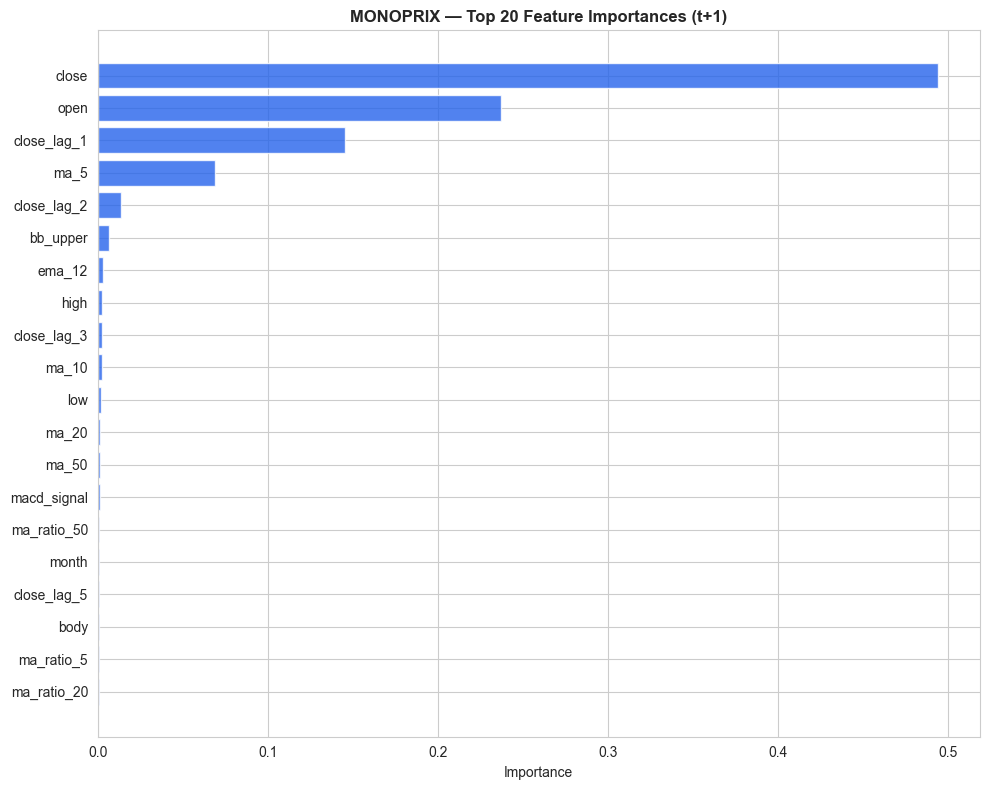

In [25]:
# Feature importance for t+1 price model
importance = xgb_models[1].feature_importances_
feat_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=True).tail(20)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feat_importance['feature'], feat_importance['importance'], color='#2563eb', alpha=0.8)
ax.set_title(f'{DEMO_NAME} — Top 20 Feature Importances (t+1)', fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

## 11. Export Models for the Forecasting Service

Save models and scalers so the FastAPI service can load them.

In [26]:
# Create models directory
MODEL_DIR = os.path.join('..', 'backend', 'services', 'forecasting', 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# Save XGBoost price models
for h in range(1, FORECAST_HORIZON + 1):
    path = os.path.join(MODEL_DIR, f'xgb_price_t{h}.json')
    xgb_models[h].save_model(path)
    print(f"Saved: {path}")

# Save XGBoost volume models
for h in range(1, FORECAST_HORIZON + 1):
    path = os.path.join(MODEL_DIR, f'xgb_volume_t{h}.json')
    volume_models[h].save_model(path)
    print(f"Saved: {path}")

# Save liquidity classifiers
for h in range(1, FORECAST_HORIZON + 1):
    path = os.path.join(MODEL_DIR, f'rf_liquidity_t{h}.joblib')
    joblib.dump(liquidity_models[h], path)
    print(f"Saved: {path}")

# Save LSTM model
lstm_path = os.path.join(MODEL_DIR, 'lstm_price.keras')
lstm_model.save(lstm_path)
print(f"Saved: {lstm_path}")

# Save scalers
joblib.dump(scaler_X, os.path.join(MODEL_DIR, 'scaler_X.joblib'))
joblib.dump(scaler_y, os.path.join(MODEL_DIR, 'scaler_y.joblib'))
print("Saved: scalers")

# Save feature columns list
joblib.dump(feature_cols, os.path.join(MODEL_DIR, 'feature_cols.joblib'))
print("Saved: feature column names")

# Save training metadata
import json
metadata = {
    'demo_stock_code': DEMO_CODE,
    'demo_stock_name': DEMO_NAME,
    'forecast_horizon': FORECAST_HORIZON,
    'lookback_lstm': LOOKBACK,
    'n_features': len(feature_cols),
    'train_end': str(X_train.index.max()),
    'test_start': str(X_test.index.min()),
    'xgb_metrics': xgb_results,
    'lstm_metrics': lstm_results,
}
with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print("Saved: metadata.json")

print("\n✅ All models and artifacts exported successfully!")

Saved: ..\backend\services\forecasting\models\xgb_price_t1.json
Saved: ..\backend\services\forecasting\models\xgb_price_t2.json
Saved: ..\backend\services\forecasting\models\xgb_price_t3.json
Saved: ..\backend\services\forecasting\models\xgb_price_t4.json
Saved: ..\backend\services\forecasting\models\xgb_price_t5.json
Saved: ..\backend\services\forecasting\models\xgb_volume_t1.json
Saved: ..\backend\services\forecasting\models\xgb_volume_t2.json
Saved: ..\backend\services\forecasting\models\xgb_volume_t3.json
Saved: ..\backend\services\forecasting\models\xgb_volume_t4.json
Saved: ..\backend\services\forecasting\models\xgb_volume_t5.json
Saved: ..\backend\services\forecasting\models\rf_liquidity_t1.joblib
Saved: ..\backend\services\forecasting\models\rf_liquidity_t2.joblib
Saved: ..\backend\services\forecasting\models\rf_liquidity_t3.joblib
Saved: ..\backend\services\forecasting\models\rf_liquidity_t4.joblib
Saved: ..\backend\services\forecasting\models\rf_liquidity_t5.joblib
Saved: ..\